In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.datasets import fetch_openml
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics.functional as metrics  
from sklearn.preprocessing import OneHotEncoder
import imageio
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_openml('mnist_784', as_frame= True, parser='auto')

In [3]:
mnist.target[0]

'5'

In [4]:
target = mnist['target']
feature = mnist['data']

In [5]:
target.value_counts()

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64

In [6]:
# target object 타입이라서 형변환
target = target.astype('int')

In [7]:
target.shape, feature.shape

((70000,), (70000, 784))

In [8]:
# # 타겟 원핫인코딩
# target = OneHotEncoder().fit_transform(target.values.reshape(-1,1))
# target.shape

In [9]:
class DLDataset(Dataset):
    
    # 초기화 함수
    def __init__(self,x_data,y_data):
        super().__init__()
        # x, y data => ndarray
        x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data
        y_data = y_data.values if isinstance(y_data, pd.DataFrame) else y_data
        
        # ndarray => tensor : 텐서화
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data)
        
    # 데이터셋의 갯수 체크 함수
    def __len__(self):
        return self.target.shape[0]
        pass
    
    # 특정 인덱스 데이터 + 라벨 반환 콜백 함수 - 튜플로 반환
    def __getitem__(self,index):
        return self.feature[index],self.target[index]
        pass

In [10]:
dataset = DLDataset(feature,target)

In [11]:
len(dataset)

70000

In [12]:
# 학습용, 검증용, 테스트용 데이터셋 나누기
seed = torch.Generator().manual_seed(42)
trainDS, valDS, testDS = random_split(dataset, [0.7,0.1,0.2], generator=seed)  # subset 타입

In [13]:
batch = 128
trainDL = DataLoader(trainDS, batch_size=batch)
validDL = DataLoader(valDS, batch_size=batch)
testDL = DataLoader(testDS, batch_size=batch)
len(trainDL), len(validDL), len(testDL)

(383, 55, 110)

In [ ]:
# 실행 디바이스 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 인스턴스
IN_DIM = dataset.feature.shape[1]
OUT_DIM = len(torch.unique(dataset.target))  # or len(np.unique(targetNP) or tragetDF.nunique()

# 손실함수
LOSS_FUNCTION =   nn.CrossEntropyLoss().to(DEVICE)

# 최적화 인스턴스

OPTIMIZER = optim.Adam(model.parameters(), lr = 1e-2)

# 스케쥴러

SCHEDULER = ReduceLROnPlateau(OPTIMIZER, 'min', patience=3)

In [21]:
# 모델 클래스 정의
class CModel(nn.Module):
    
    # 모델 구조 설정
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.input_layer = nn.Linear(in_dim, 100)
        self.relu = nn.ReLU()  # 0보다 작거나 같으면 0 / 0보다 크면 1
        self.hidden_layer = nn.Linear(100, 50) 
        self.output_layer = nn.Linear(50, out_dim) 
        
    # 순방향 학습 진행 콜백 함수
    def forward(self, x):
        y = self.input_layer(x)
        y = self.relu(y)
        y = self.hidden_layer(y)
        y = self.relu(y)
        y = self.output_layer(y)
        return y
    
    # model => self
    def training(self, dataLoader):
        # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화
        self.train() 
        
        # 배치크기만큼 학습진행 및 저장
        train_loss = 0
        train_acc = 0
        for cnt, (feature, target) in enumerate(dataLoader):
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            # 학습
            pre_target = self(feature)  # 수정된 부분
    
            # 손실계산
            loss = LOSS_FUNCTION(pre_target, target)
            train_loss += loss.item()
            
            # 정확도 
            acc = metrics.accuracy(pre_target, target, task='multiclass', num_classes=len(torch.unique(dataset.target)))
            train_acc += acc.item()
            
            # W, b 업데이트 
            OPTIMIZER.zero_grad()
            loss.backward()
            OPTIMIZER.step()
            # 배치 사이즈 단위 학습 진행 메시지 출력
            # print(f'[{cnt}] : [Train batch loss] ==> {loss}')
    
        # 에포크 단위 학습 진행 메시지 출력
        print(f'[Train loss] ==> {train_loss / len(dataLoader)}    [Train Accuracy] ==> {train_acc / len(dataLoader)}')
        
        return train_loss / len(dataLoader), train_acc / len(dataLoader)
    
    
    # 검증 및 평가 진행 함수
    # 매개변수 dataLoader : 검증 또는 테스트 데이터셋에 대한 Loader
    def testing(self, dataLoader):
        # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 비활성화
        self.eval()
        
        with torch.no_grad():
            # 배치크기만큼 학습진행
            val_loss = 0    
            val_acc = 0
            for cnt, (feature, target) in enumerate(dataLoader):
                feature, target = feature.to(DEVICE), target.to(DEVICE)
                # 학습
                pre_target = self(feature)  # 수정된 부분
        
                # 손실계산
                loss = LOSS_FUNCTION(pre_target, target)
                val_loss += loss.item()
                
                # 정확도 
                acc = metrics.accuracy(pre_target, target, task='multiclass', num_classes=len(torch.unique(dataset.target)))
                val_acc += acc.item()
                
                # 배치 사이즈 단위 학습 진행 메시지 출력
                # print(f'[{cnt}] : [Train batch loss] ==> {loss}')
    
        # 에포크 단위 학습 진행 메시지 출력
        print(f'[Valid loss] ==> {val_loss / len(dataLoader)}    [Valid Accuracy] ==> {val_acc / len(dataLoader)}')
        
        return val_loss / len(dataLoader), val_acc / len(dataLoader)
    
    # 예측 함수
    def predict(self, dataset, idx):
        self.eval()
        
        img, ytrue = dataset.dataset[idx][0], dataset.dataset[idx][1]
    
        with torch.no_grad():
            ypre = self(img.unsqueeze(0))  # 수정된 부분
            ypre = torch.argmax(ypre, dim=1).item()
            plt.imshow(testDL.dataset[idx][0].numpy().reshape(28, 28), cmap='gray_r')
            plt.title(f'[Predict : {ypre}]')
            plt.xticks([])
            plt.yticks([])
            plt.show()  # 수정된 부분


In [ ]:
model = CModel(IN_DIM, OUT_DIM).to(DEVICE)

In [27]:
EPOCHS = 10
for eps in range(EPOCHS):
    
    print(f'[{eps+1}/{EPOCHS}]')
    # 학습
    train_loss, train_acc = model.training(trainDL)
    
    # 검증
    val_loss, val_acc = model.testing(validDL)
    
    
    # 조기 종료 기능 => 조건 : val_loss가 지정된 횟수 이상 개선이 안되면 학습 종료
    if SCHEDULER.num_bad_epochs > SCHEDULER.patience:
        print(f"Early stopping at epoch {eps}")
        break

[1/10]


TypeError: 'bool' object is not callable

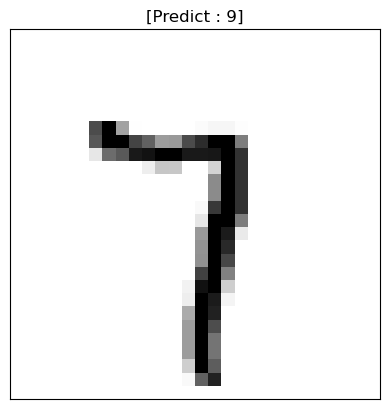

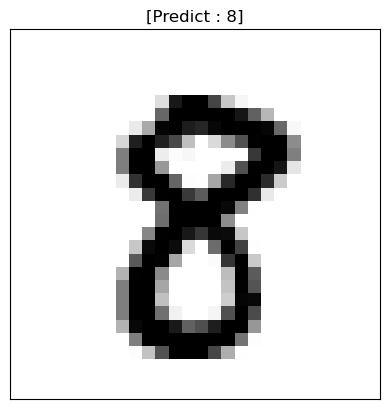

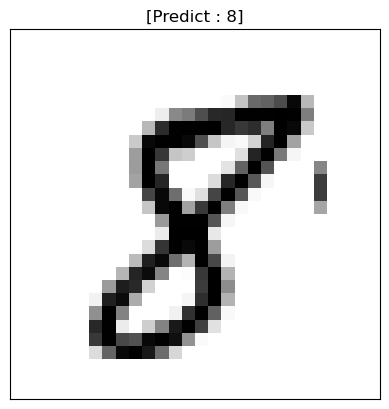

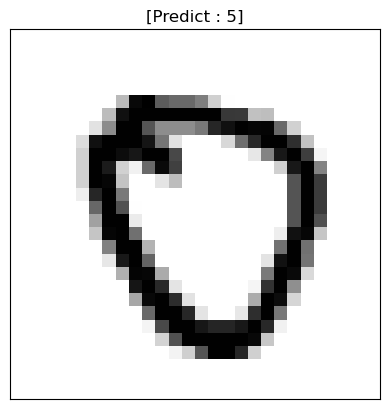

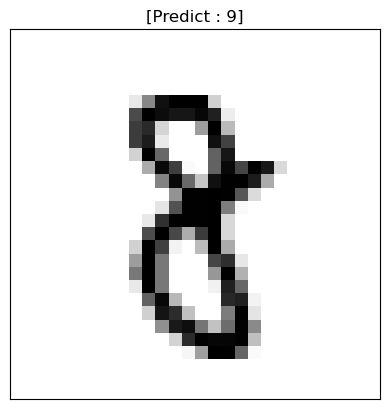

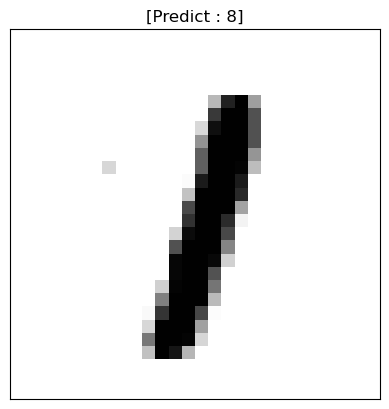

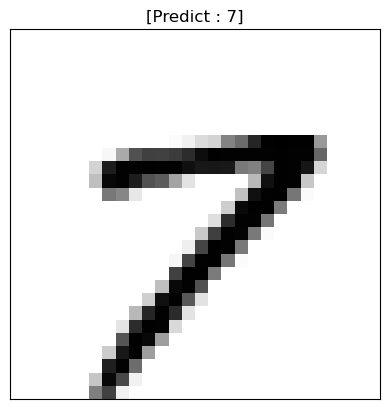

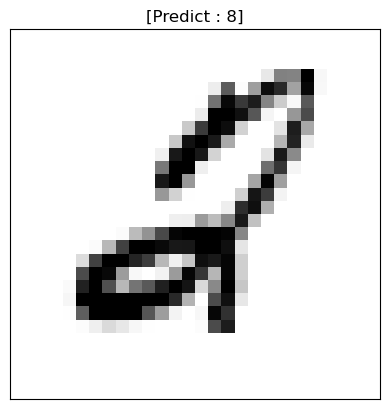

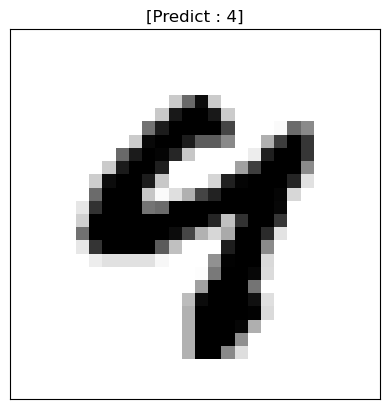

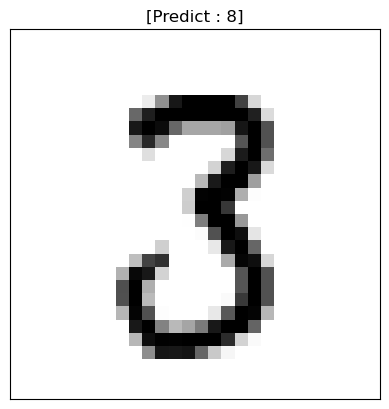

In [26]:
for i in range(1,11):
    model.predict(testDL,i)